# RC fitting strategy perf comparison (WheatFspm)

The following notebook analyzes and compares the results generated by `2022_04_06_optimizing_fitting_strategy.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
score_files = [
  'scores_3_folds.csv',
  'scores_4_folds.csv',
  'scores_5_folds.csv',
  'scores_LeaveOneOut.csv'
]

DATASET = 'HydroShoot_large'

### Loading the experiment scores

In [3]:
data = None

for filename in score_files:
  df = pd.read_csv(filename, index_col=0)
  if data is None:
    data = df
  else:
    data = pd.concat((data, df))

strategies = data['strategy'].unique().tolist()
targets = data['target'].unique().tolist()
state_vars = data['state_var'].unique().tolist()
datasets = data['dataset'].unique().tolist()

data = data.set_index(['target', 'state_var', 'dataset', 'strategy'])
data = data.sort_values(['target', 'state_var', 'dataset', 'strategy'], axis=0)
data.sample(3)

,,,,test_score,train_mean,train_std,cv_mean,cv_std
target,state_var,dataset,strategy,,,,,
output_Rg,state_Eabs,HydroShoot_large,LeaveOneOut,-0.364293,-0.351565,0.001869,-0.463374,0.250438
input_hs,state_E,HydroShoot_large,3_folds,-0.618321,-0.471160,0.013554,-0.511356,0.044259
output_An,state_gs,HydroShoot_large,3_folds,-0.519314,-0.493228,0.006318,-0.498688,0.012507


### Comparing test score performance between strategies

Score distribution per strategy:

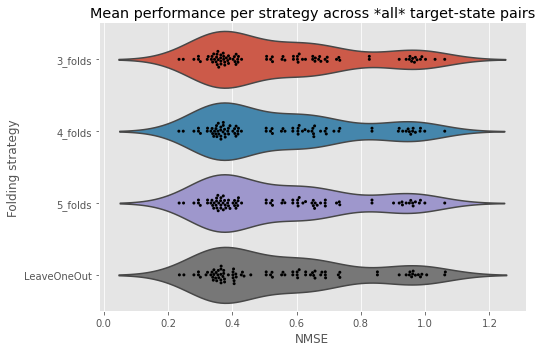

In [4]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, DATASET, :].reset_index()
  plot_data['test_score'] *= -1

  g = sns.catplot(y="strategy", x="test_score", kind="violin", orient='h', data=plot_data, height=5, aspect=1.5, inner=None)
  sns.swarmplot(y="strategy", x="test_score", color="k", size=3, data=plot_data, ax=g.ax)
  g.set(title='Mean performance per strategy across *all* target-state pairs', ylabel='Folding strategy', xlabel='NMSE') 
  g.tight_layout()
  plt.show()

Score distribution per strategy for increasing percentile

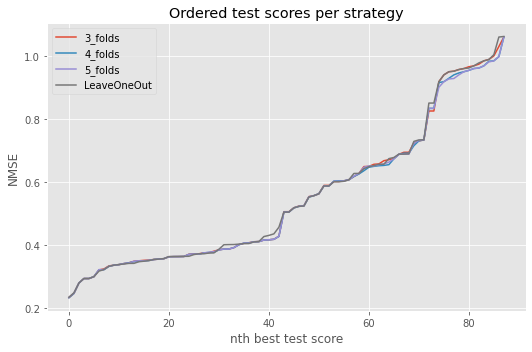

In [5]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(5*1.5, 5))
  
  for strat in strategies:
    plot_data = data.loc[:, :, DATASET, strat].reset_index()
    plot_data = plot_data.sort_values(by='test_score', ascending=False)
    plot_data['test_score'] *= -1
    plot_data = plot_data.reset_index()

    plt.plot(plot_data.index, plot_data['test_score'], label=strat)

  plt.legend()
  plt.ylabel('NMSE')
  plt.xlabel('nth best test score')
  plt.title('Ordered test scores per strategy')
  plt.tight_layout()
    

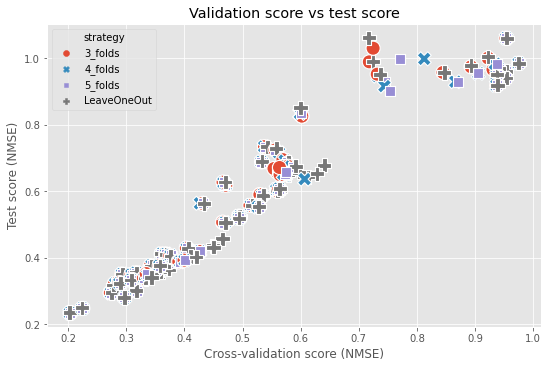

In [11]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, DATASET, :]
  plot_data['test_score'] *= -1
  plot_data['train_mean'] *= -1
  fig, ax = plt.subplots(1, 1, figsize=(1.5 * 5, 5), constrained_layout=True)
  sns.scatterplot(x='train_mean', y='test_score', hue='strategy', style='strategy', s=200, data=plot_data, ax=ax)
  ax.set_title('Validation score vs test score')
  ax.set_xlabel('Cross-validation score (NMSE)')
  ax.set_ylabel('Test score (NMSE)')

  # label outliers
  outlier_data = plot_data[plot_data['test_score'] > 5]

  def print_annotation(row):
    ax.text(row['train_mean'], row['test_score'], row['target'], rotation=0)

  outlier_data.apply(print_annotation, axis=1)

  plt.show()

In [10]:
print(data.groupby('strategy').median())

             test_score  train_mean  train_std   cv_mean    cv_std
strategy                                                          
3_folds       -0.506753   -0.448486   0.008060 -0.502912  0.022076
4_folds       -0.505440   -0.446926   0.007624 -0.485817  0.027006
5_folds       -0.505440   -0.449766   0.006379 -0.502074  0.033003
LeaveOneOut   -0.505440   -0.467981   0.002655 -0.821970  0.584900
